In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler , RobustScaler , MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, silhouette_score
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import KMeans , AgglomerativeClustering 
from sklearn.decomposition import PCA




In [138]:
df=pd.read_csv('modifed_data.csv')

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31566 entries, 0 to 31565
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_age                      30948 non-null  float64
 1   job_type                          31566 non-null  object 
 2   marital                           31416 non-null  object 
 3   education                         31566 non-null  object 
 4   default                           31566 non-null  object 
 5   balance                           31168 non-null  float64
 6   housing_loan                      31566 non-null  object 
 7   personal_loan                     31417 non-null  object 
 8   communication_type                31566 non-null  object 
 9   month                             31566 non-null  object 
 10  num_contacts_in_campaign          31454 non-null  float64
 11  num_contacts_prev_campaign        31566 non-null  int64  
 12  prev

In [4]:
df.isnull().mean()*100

customer_age                        1.957803
job_type                            0.000000
marital                             0.475195
education                           0.000000
default                             0.000000
balance                             1.260850
housing_loan                        0.000000
personal_loan                       0.472027
communication_type                  0.000000
month                               0.000000
num_contacts_in_campaign            0.354812
num_contacts_prev_campaign          0.000000
prev_campaign_outcome               0.000000
term_deposit_subscribed             0.000000
call_dura_in_min                    0.978901
day_month_binned                    0.000000
new_client_contact_this_campaign    0.000000
dtype: float64

In [5]:
 df.select_dtypes('object').columns

Index(['job_type', 'marital', 'education', 'default', 'housing_loan',
       'personal_loan', 'communication_type', 'month', 'prev_campaign_outcome',
       'day_month_binned'],
      dtype='object')

In [6]:
num_col=['customer_age', 'balance','num_contacts_in_campaign','call_dura_in_min']

In [7]:
cat_col=['personal_loan', 'marital'] 

In [8]:
x=df.drop(['term_deposit_subscribed'] , axis=1)
y=df['term_deposit_subscribed']

## Kmeans

In [9]:
steps_1=list()
steps_1.append(('imputer',  SimpleImputer(strategy='most_frequent')))
steps_1.append(('Encoder',OneHotEncoder(sparse=False , drop='first') ))
pipline_1= Pipeline(steps=steps_1)

In [10]:
pipline_1

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('Encoder', OneHotEncoder(drop='first', sparse=False))])

In [11]:
col_trasformer= ColumnTransformer(transformers=[('category_trans_1',pipline_1, cat_col), ('num_trans', KNNImputer(),num_col),
                                                ('category_trans_2',BinaryEncoder(),['job_type', 'education', 'default', 'housing_loan','communication_type', 'month', 'prev_campaign_outcome','day_month_binned'])]
                                  ,remainder='passthrough')

In [12]:
inertia = list()
k_range = range(2 , 20)
for k in k_range:
    steps=list()
    steps.append(('col_trans',col_trasformer ))
    #steps.append(('ROS',SMOTE(sampling_strategy=0.2)))
    #steps.append(('RUS',RandomUnderSampler(sampling_strategy=0.5)))
    steps.append(("Scaler" , MinMaxScaler()))
    steps.append(("Model" , KMeans(n_clusters=k)))
    pipeline = Pipeline(steps = steps)
    pipeline.fit(df)
    inertia.append(pipeline["Model"].inertia_)

<AxesSubplot:>

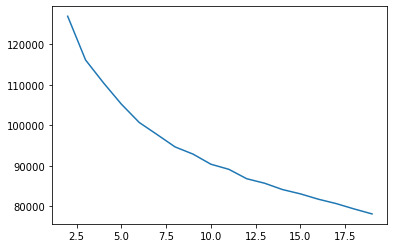

In [13]:
sns.lineplot(x = k_range , y = inertia)

In [14]:
from kneed import KneeLocator
k= KneeLocator(k_range, inertia, curve='convex', direction='decreasing')

In [15]:
k.elbow

8

## hairarical

In [16]:
steps = list()
steps.append(('col_trans',col_trasformer ))
steps.append(("Scaler" , RobustScaler()))
pipeline = Pipeline(steps = steps)

In [17]:
df_modi=pipeline.fit_transform(df)

In [82]:
df_modi.shape

(31566, 32)

### dendogram

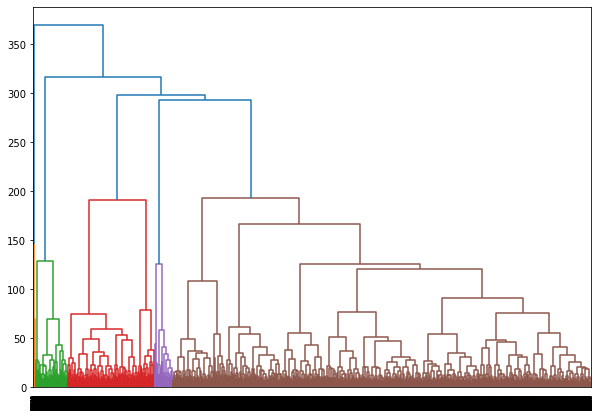

In [18]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(10,7))
dend = sch.dendrogram(sch.linkage(df_modi , method="ward"))

In [19]:
silhoute = list()
cluster_range = range(2,6)
for c in cluster_range:
    steps = list()
    steps.append(('col_trans',col_trasformer ))
    steps.append(("Scaler" , RobustScaler()))
    steps.append(("PCA",PCA(0.95)))
    steps.append(("Model" , AgglomerativeClustering(n_clusters=c , linkage="ward")))
    pipeline = Pipeline(steps = steps)
    pipeline.fit(df)
    silhoute.append(silhouette_score(df_modi ,pipeline["Model"].labels_ ))

<AxesSubplot:>

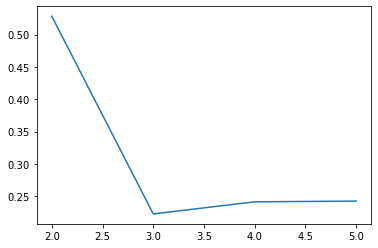

In [20]:
sns.lineplot(x= cluster_range , y= silhoute)

In [21]:
#for n_clusters=4

In [22]:
steps = list()
steps.append(('col_trans',col_trasformer ))
steps.append(("Scaler" , RobustScaler()))
steps.append(("PCA",PCA(0.95)))
steps.append(("Model" , AgglomerativeClustering(n_clusters=4 , linkage="ward")))
pipeline = Pipeline(steps = steps)

In [140]:
df["Cluster"] = pipeline.fit_predict(df)

In [141]:
df['Cluster'].value_counts()

1    24424
2     5096
0     1186
3      860
Name: Cluster, dtype: int64

In [25]:
transformed_df = pipeline["PCA"].fit_transform(df_modi)

In [26]:
transformed_df.shape

(31566, 17)

In [142]:
df

,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,month,num_contacts_in_campaign,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed,call_dura_in_min,day_month_binned,new_client_contact_this_campaign,Cluster
0,28.0,management,single,tertiary,no,285.0,yes,no,unknown,jun,4.0,0,unknown,0,5.050000,>20,1,1
1,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,nov,2.0,1,other,0,2.383333,10:20,0,2
2,46.0,technician,married,secondary,no,656.0,no,no,cellular,feb,4.0,0,unknown,0,1.683333,<11,1,1
3,34.0,services,single,secondary,no,2.0,yes,no,unknown,may,3.0,0,unknown,0,2.116667,10:20,1,1
4,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,may,2.0,0,unknown,0,0.816667,10:20,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31561,58.0,admin.,married,secondary,no,567.0,yes,no,cellular,feb,2.0,3,other,0,1.650000,<11,0,2
31562,51.0,management,married,tertiary,no,1072.0,no,no,unknown,jun,7.0,0,unknown,0,0.516667,10:20,1,1
31563,41.0,unemployed,married,primary,no,242.0,yes,no,unknown,may,2.0,0,unknown,0,1.483333,>20,1,1
31564,48.0,services,married,secondary,no,2699.0,no,no,cellular,aug,6.0,0,unknown,0,3.600000,10:20,1,1


#  Market Segments

### cluster 0

In [143]:
cluster_0=df[df['Cluster']==0]

In [144]:
cluster_0.describe()    #upper low

,customer_age,balance,num_contacts_in_campaign,num_contacts_prev_campaign,term_deposit_subscribed,call_dura_in_min,new_client_contact_this_campaign,Cluster
count,1165.000000,1183.000000,1178.000000,1186.000000,1186.000000,1168.000000,1186.000000,1186.0
mean,43.787983,12373.438715,2.360781,0.450253,0.175379,5.375014,0.800169,0.0
std,11.932680,8695.167753,2.008408,1.088321,0.380452,5.452761,0.400042,0.0
min,20.000000,1314.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,34.000000,7886.500000,1.000000,0.000000,0.000000,1.900000,1.000000,0.0
50%,42.000000,9795.000000,2.000000,0.000000,0.000000,3.266667,1.000000,0.0
75%,53.000000,13566.500000,3.000000,0.000000,0.000000,6.658333,1.000000,0.0
max,86.000000,102128.000000,20.000000,7.000000,1.000000,29.766667,1.000000,0.0


In [145]:
cluster_0.term_deposit_subscribed.value_counts()

0    978
1    208
Name: term_deposit_subscribed, dtype: int64

In [146]:
cluster_0[['customer_age','balance','call_dura_in_min','num_contacts_in_campaign','num_contacts_prev_campaign']].apply(np.mean).T

customer_age                     43.787983
balance                       12373.438715
call_dura_in_min                  5.375014
num_contacts_in_campaign          2.360781
num_contacts_prev_campaign        0.450253
dtype: float64

## cluster 1

In [147]:
cluster_1=df[df['Cluster']==1]

In [148]:
cluster_1.describe()  #mid

,customer_age,balance,num_contacts_in_campaign,num_contacts_prev_campaign,term_deposit_subscribed,call_dura_in_min,new_client_contact_this_campaign,Cluster
count,23940.000000,24110.000000,24343.000000,24424.000000,24424.000000,24196.000000,24424.000000,24424.0
mean,40.524353,904.197345,2.464487,0.024198,0.087005,4.350618,0.983582,1.0
std,10.726590,1363.362847,1.846361,0.206624,0.281848,4.394101,0.127080,0.0
min,18.000000,-8020.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,32.000000,49.000000,1.000000,0.000000,0.000000,1.733333,1.000000,1.0
50%,39.000000,390.000000,2.000000,0.000000,0.000000,3.000000,1.000000,1.0
75%,48.000000,1206.000000,3.000000,0.000000,0.000000,5.316667,1.000000,1.0
max,95.000000,8727.000000,15.000000,4.000000,1.000000,62.883333,1.000000,1.0


In [149]:
cluster_1.term_deposit_subscribed.value_counts()

0    22299
1     2125
Name: term_deposit_subscribed, dtype: int64

In [150]:
cluster_1[['customer_age','balance','call_dura_in_min','num_contacts_in_campaign','num_contacts_prev_campaign']].apply(np.mean).T

customer_age                   40.524353
balance                       904.197345
call_dura_in_min                4.350618
num_contacts_in_campaign        2.464487
num_contacts_prev_campaign      0.024198
dtype: float64

## cluster 2

In [151]:
cluster_2=df[df['Cluster']==2]

In [152]:
cluster_2.describe()    #high

,customer_age,balance,num_contacts_in_campaign,num_contacts_prev_campaign,term_deposit_subscribed,call_dura_in_min,new_client_contact_this_campaign,Cluster
count,5003.000000,5027.000000,5076.000000,5096.000000,5096.000000,5040.000000,5096.0,5096.0
mean,39.305617,1082.519196,2.019898,3.027080,0.200942,3.910496,0.0,2.0
std,10.509946,1483.538808,1.487484,2.527426,0.400744,3.013194,0.0,0.0
min,18.000000,-1880.000000,1.000000,1.000000,0.000000,0.000000,0.0,2.0
25%,32.000000,144.500000,1.000000,1.000000,0.000000,1.833333,0.0,2.0
50%,37.000000,520.000000,2.000000,2.000000,0.000000,3.116667,0.0,2.0
75%,46.000000,1440.000000,2.000000,4.000000,0.000000,5.166667,0.0,2.0
max,93.000000,13052.000000,16.000000,15.000000,1.000000,24.950000,0.0,2.0


In [153]:
cluster_2.term_deposit_subscribed.value_counts() 

0    4072
1    1024
Name: term_deposit_subscribed, dtype: int64

In [154]:
cluster_2[['customer_age','balance','call_dura_in_min','num_contacts_in_campaign','num_contacts_prev_campaign']].apply(np.mean).T

customer_age                    39.305617
balance                       1082.519196
call_dura_in_min                 3.910496
num_contacts_in_campaign         2.019898
num_contacts_prev_campaign       3.027080
dtype: float64

## cluster 3

In [155]:
cluster_3=df[df['Cluster']==3]

In [156]:
cluster_3.describe()   #low

,customer_age,balance,num_contacts_in_campaign,num_contacts_prev_campaign,term_deposit_subscribed,call_dura_in_min,new_client_contact_this_campaign,Cluster
count,840.000000,848.000000,857.000000,860.000000,860.000000,853.000000,860.000000,860.0
mean,40.232143,878.528302,16.680280,0.002326,0.031395,2.496639,0.997674,3.0
std,10.052054,1701.035760,7.099789,0.048196,0.174485,3.551414,0.048196,0.0
min,21.000000,-1609.000000,7.000000,0.000000,0.000000,0.000000,0.000000,3.0
25%,32.000000,4.000000,12.000000,0.000000,0.000000,0.433333,1.000000,3.0
50%,38.000000,252.000000,14.000000,0.000000,0.000000,1.266667,1.000000,3.0
75%,47.250000,1000.250000,19.000000,0.000000,0.000000,2.900000,1.000000,3.0
max,97.000000,13491.000000,63.000000,1.000000,1.000000,27.233333,1.000000,3.0


In [157]:
cluster_3.term_deposit_subscribed.value_counts() 

0    833
1     27
Name: term_deposit_subscribed, dtype: int64

In [158]:
cluster_3[['customer_age','balance','call_dura_in_min','num_contacts_in_campaign','num_contacts_prev_campaign']].apply(np.mean).T

customer_age                   40.232143
balance                       878.528302
call_dura_in_min                2.496639
num_contacts_in_campaign       16.680280
num_contacts_prev_campaign      0.002326
dtype: float64

In [159]:
#get the total size of the cluster
df.Cluster.size

31566

In [160]:
#get the total values in each segment 
df.Cluster.value_counts()

1    24424
2     5096
0     1186
3      860
Name: Cluster, dtype: int64

In [161]:
pd.Series.sort_index(df.Cluster.value_counts())

0     1186
1    24424
2     5096
3      860
Name: Cluster, dtype: int64

In [162]:
size=pd.Series.sort_index(df.Cluster.value_counts())

In [163]:
size=pd.concat([pd.Series(df.Cluster.size), pd.Series.sort_index(df.Cluster.value_counts())])

In [164]:
size

0    31566
0     1186
1    24424
2     5096
3      860
dtype: int64

In [165]:
#seg_size 
seg_size= pd.DataFrame(data=size, columns=['seg_size'])

In [166]:
seg_size

,seg_size
0,31566
0,1186
1,24424
2,5096
3,860


In [167]:
p=size/df.Cluster.size

In [168]:
#seg_ditribution
seg_PCT= pd.DataFrame(p, columns= ['seg_PCT'])

In [169]:
seg_PCT

,seg_PCT
0,1.000000
0,0.037572
1,0.773744
2,0.161440
3,0.027245


In [170]:
seg_PCT.T

,0,0,1,2,3
seg_PCT,1.0,0.037572,0.773744,0.16144,0.027245


In [171]:
p

0    1.000000
0    0.037572
1    0.773744
2    0.161440
3    0.027245
dtype: float64

In [172]:
# Concatenating the Segment Size and Segment Percentage:
pd.concat([seg_size.T, seg_PCT.T], axis=0)

,0,0,1,2,3
seg_size,31566.0,1186.000000,24424.000000,5096.00000,860.000000
seg_PCT,1.0,0.037572,0.773744,0.16144,0.027245
